In [1]:
import numpy as np
import pandas as pd

import pandas_profiling as pp
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

TRAINPATH = '/home/adi/kagle_twarz/dane/training.csv'
#TESTPATH = '/home/izinizik/kagle_twarz/test.csv'

In [2]:
use_cuda = torch.cuda.is_available()
#use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
df_train = pd.read_csv(TRAINPATH)
#df_test = pd.read_csv(TESTPATH)

In [4]:
df_train['Image'] = df_train['Image'].apply(lambda im: np.fromstring(im, sep=' '))

In [5]:
names = ['left_eye_center_x','left_eye_center_y','Image']

In [6]:
df_train_left_eye_center = df_train[names].dropna()

In [7]:
df_train_left_eye_center.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7039 entries, 0 to 7048
Data columns (total 3 columns):
left_eye_center_x    7039 non-null float64
left_eye_center_y    7039 non-null float64
Image                7039 non-null object
dtypes: float64(2), object(1)
memory usage: 220.0+ KB


In [8]:
X = np.vstack(df_train_left_eye_center.iloc[:,2].values)/ 255. 
y = df_train_left_eye_center.iloc[:,:2].values

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [10]:
criterion = nn.MSELoss().to(device)

In [11]:
const_prediction_train = np.repeat(y_train.mean(axis=0).reshape(1,-1), y_train.shape[0], axis=0)
criterion(torch.tensor(const_prediction_train), torch.tensor(y_train)).item()

10.911206218975417

In [12]:
const_prediction_valid = np.repeat(y_train.mean(axis=0).reshape(1,-1), y_valid.shape[0], axis=0)
criterion(torch.tensor(const_prediction_valid).float(), torch.tensor(y_valid).float()).item()

10.92607593536377

In [13]:
regresion_line = np.linalg.lstsq(np.column_stack([X_train, np.ones(len(X_train))]), y_train, rcond=None)[0]

In [14]:
linear_prediction_train = np.dot(X_train,regresion_line[:-1]) + regresion_line[-1:]
criterion(torch.tensor(linear_prediction_train), torch.tensor(y_train)).item()

0.1338760072151573

In [15]:
linear_prediction_valid = np.dot(X_valid,regresion_line[:-1]) + regresion_line[-1:]
criterion(torch.tensor(linear_prediction_valid), torch.tensor(y_valid)).item()

46.19477237970597

In [13]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.data = torch.tensor(X).type(dtype).reshape(-1,1,96,96).to(device)
        self.label = torch.tensor(y).type(dtype).to(device)
        self.len = X.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return self.len

In [14]:
dataset_train = MyDataset(X_train, y_train)
train_loader = DataLoader(dataset=dataset_train,
                          batch_size=100,
                          shuffle=True,
                          num_workers=4)

In [15]:
dataset_valid = MyDataset(X_valid, y_valid)
valid_loader = DataLoader(dataset=dataset_valid,
                          batch_size=100,
                          shuffle=True,
                          num_workers=4)

In [16]:
class ConvNet(nn.Module):

    def __init__(self):

        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.2)
        self.drop3 = nn.Dropout(p = 0.2)
        self.drop4 = nn.Dropout(p = 0.2)
        self.drop5 = nn.Dropout(p = 0.2)
        
        self.fc1 = nn.Linear(in_features=32*3*3, out_features=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
      
    def forward(self, x):
        
        x = self.drop1(self.pool(F.relu(self.conv1(x))))
        x = self.drop2(self.pool(F.relu(self.conv2(x))))
        x = self.drop3(self.pool(F.relu(self.conv3(x))))
        x = self.drop4(self.pool(F.relu(self.conv4(x))))
        x = self.drop5(self.pool(F.relu(self.conv5(x))))
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)

        return(x)

In [17]:
def train_net(net, n_epochs=500, store_every=10, print_every=10):

    hist = {'train': [], 'valid': []}
    
    
    for epoch in range(n_epochs): 
        
        loss_sum = 0.0
        n_loss = 0
        net.train()
        
        for i, data in enumerate(train_loader, 0):
            input_train, label_train = data
            output_train = net(input_train) 
            loss = criterion(output_train, label_train)
            loss_sum += loss.item()
            n_loss += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch % store_every == 0:               
            hist['train'].append(loss_sum/n_loss)
            loss_sum_valid = 0.0
            n_loss_valid = 0
            net.eval()
            for i, data in enumerate(valid_loader, 0):
                input_valid, label_valid = data
                output_valid = net(input_valid) 
                loss_valid = criterion(output_valid, label_valid)
                loss_sum_valid += loss_valid.item()
                n_loss_valid += 1
            hist['valid'].append(loss_sum_valid/n_loss_valid)


        if epoch % print_every == 0:        
            print('Epoch: {}, Loss train: {}, Loss valid: {}'.format(epoch+1, loss_sum/n_loss, loss_sum_valid/n_loss_valid))
    print('Epoch: {}, Loss train: {}, Loss valid: {}'.format(epoch+1, loss_sum/n_loss, loss_sum_valid/n_loss_valid))
    return net, hist

In [18]:
convnet = ConvNet().to(device)

In [21]:
optimizer = optim.Adam(params = convnet.parameters(), lr = 0.001)

In [22]:
Convnet_trained, hist = train_net(convnet, n_epochs=40, store_every=5, print_every=5)

Epoch: 1, Loss train: 11.449505428098282, Loss valid: 11.103148831261528
Epoch: 6, Loss train: 11.417046151071224, Loss valid: 10.93132864104377
Epoch: 11, Loss train: 11.370264503191102, Loss valid: 10.943273862202963
Epoch: 16, Loss train: 11.343452804493454, Loss valid: 11.437744352552626
Epoch: 21, Loss train: 11.249792656808529, Loss valid: 11.075146171781752
Epoch: 26, Loss train: 11.30871701690386, Loss valid: 10.832459449768066
Epoch: 31, Loss train: 11.35603991994318, Loss valid: 10.867365333769056
Epoch: 36, Loss train: 11.260062937466603, Loss valid: 10.87295905749003
Epoch: 40, Loss train: 11.20507515601392, Loss valid: 10.87295905749003


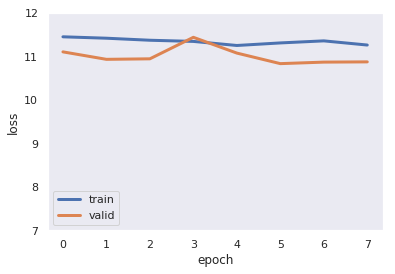

In [24]:
 def train_valid_plot(train, valid):
    plt.plot(train, linewidth=3, label="train")
    plt.plot(valid, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.ylim(7, 12) 
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
    
train_valid_plot(hist['train'], hist['valid'])

In [25]:
def plot_sample(images_array, dim=1, key=np.empty([10000,0]), key_pred=np.empty([10000,0])):
    
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    sample = np.random.choice(len(images_array), dim*dim)
    for i in range(dim*dim):
        ax = fig.add_subplot(dim, dim, i + 1, xticks=[], yticks=[])
        ax.imshow(images_array[sample[i]].reshape(96,96), cmap='gray')
        ax.scatter(key[sample[i],0::2], key[sample[i],1::2], s=20, marker='.', c='red')
        ax.scatter(key_pred[sample[i],0::2], key_pred[sample[i],1::2], s=20, marker='.', c='blue')

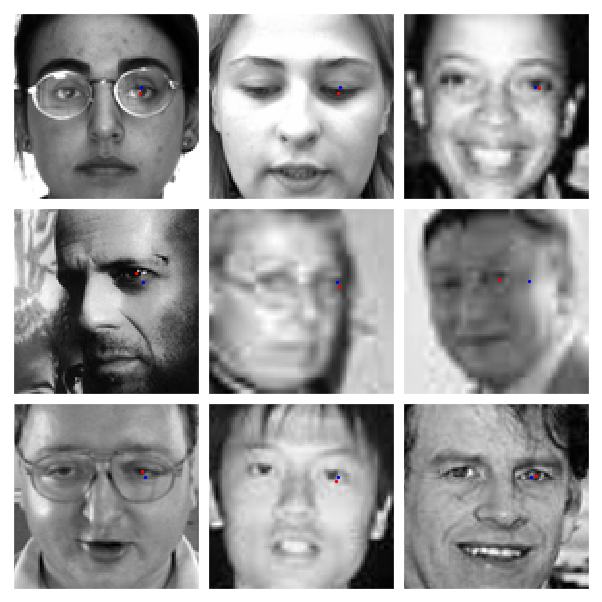

In [27]:
y_pred = Convnet_trained(torch.tensor(X_valid[200:300]).float().reshape(-1,1,96,96)).detach().numpy()
plot_sample(X_valid[200:300], dim=3, key=y_valid[200:300], key_pred=y_pred) #*48+48

In [28]:
torch.save(Convnet_trained.state_dict(), 'wagi_left_eye_center.pt')

In [20]:
convnet.load_state_dict(torch.load('wagi_left_eye_center.pt'))

In [29]:
y_pred.T

array([[67.4304  , 67.4304  , 65.281944, 66.762146, 67.4304  , 67.4304  ,
        64.612946, 66.70887 , 63.91199 , 65.27978 , 67.4304  , 65.31025 ,
        66.762695, 66.00164 , 66.70887 , 66.72316 , 66.04825 , 66.72316 ,
        65.994225, 65.34101 , 66.73793 , 64.65873 , 65.331955, 66.05492 ,
        66.002716, 66.70146 , 66.00164 , 66.71595 , 66.02442 , 66.70146 ,
        66.008995, 64.65106 , 67.4304  , 66.72316 , 65.37224 , 66.762146,
        65.3495  , 66.70887 , 66.73793 , 66.02518 , 66.73793 , 66.0307  ,
        67.4304  , 65.29549 , 65.357475, 67.4304  , 65.98701 , 67.4304  ,
        63.944283, 66.73166 , 65.39646 , 67.4304  , 67.4304  , 67.4304  ,
        65.29455 , 66.762146, 67.4304  , 66.03367 , 66.73166 , 66.70887 ,
        66.00164 , 66.72316 , 66.064705, 66.01641 , 67.4304  , 66.70146 ,
        66.71595 , 67.4304  , 66.03919 , 66.762695, 66.762146, 67.4304  ,
        66.017204, 66.72316 , 66.02348 , 66.70146 , 65.98701 , 66.762695,
        66.73793 , 67.4304  , 66.71595